In [4]:
import numpy as np
import pandas as pd
from math import sqrt
from typing import Tuple, List, Set, Dict
from matplotlib import pyplot as plt

%matplotlib inline

In [5]:
%pwd

'/Users/rmn/masterThesis/eda-gp-2020/experiments/airfoil_firstGen/airfoil_1gen_1hl_fhn'

In [6]:
def df_from_path(path: str) -> pd.DataFrame:
    return pd.read_csv(
        filepath_or_buffer=path,
        sep="?",
    )

AIRFOIL_PATH = "./results.csv"
AIRFOIL_RESULTS = df_from_path(AIRFOIL_PATH)

In [7]:
%%bash
# check if csv contains same number of rows for both algorithms

printf "Pre-trained DAE-LSTM Cases:" ; cat ./results.csv | grep ^pt  | wc -l 
printf "Regular DAE-LSTM Cases    :" ; cat ./results.csv | grep ^dae | wc -l 

# 10 runs * 2 generations (0-1) = 20

Pre-trained DAE-LSTM Cases:      20
Regular DAE-LSTM Cases    :      20


In [8]:
RUNS=10
GENERATIONS=1
HIDDENLAYERS=1

In [9]:
def split_df(df: pd.DataFrame, dir1: str, dir2: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return df.query("directory == @dir1").copy(), df.query("directory == @dir2").copy()

pt_results, reg_results = split_df(AIRFOIL_RESULTS, "pt_dae_gp", "dae_gp")
print("Equal number of records (pt/reg): ", pt_results.shape == reg_results.shape)

Equal number of records (pt/reg):  True


In [10]:
D = {
    "hidden_layers": 1,
    "gen_max": 1,
    "n_runs": 10
}

def validate(D: Dict, df: pd.DataFrame):

    def check_hidden_layers(df: pd.DataFrame, value: str) -> bool:
        return all(df['hidden_layers'] == value)

    print("Correct number of Hidden Layers: ", check_hidden_layers(df, D["hidden_layers"]))


    def check_generations_range(df: pd.DataFrame, minimum: int, maximum: int) -> bool:
        return all(df['generation'] >= minimum) and all(df['generation'] <= maximum)

    print("Correct number of Generations: ", check_generations_range(df, 0, D["gen_max"]))

    def get_ind_rund_ids(df):
        return len({x for x in df.rund_id})

    print("Minimum number of Runs reached: ", get_ind_rund_ids(df) >= D["n_runs"])


print("Regular Results:\n...")
validate(D, reg_results) 
print("\nPre-trained Results:\n...")
validate(D, pt_results)
print()

Regular Results:
...
Correct number of Hidden Layers:  True
Correct number of Generations:  True
Minimum number of Runs reached:  True

Pre-trained Results:
...
Correct number of Hidden Layers:  True
Correct number of Generations:  True
Minimum number of Runs reached:  True



In [11]:
for a, b in zip(pt_results["hidden_dim"].values, pt_results["hidden_dim"].values):
    if a == "None" and b == "None":
        continue
    else:
        print(f"dim={a}", a==b)

dim=100 True
dim=100 True
dim=100 True
dim=100 True
dim=100 True
dim=100 True
dim=100 True
dim=100 True
dim=100 True
dim=100 True


In [12]:
def get_test_nums(df) -> Set[int]:
    return {x for x in df.test_no}


def get_errs_dict(df, test_no_arr, gen=1):
    
    assert "training_errors" in df.columns and "testing_errors" in df.columns

    def __get_errs(df, test_no, err, gen=1):
        ret = df.loc[(df['test_no'] == test_no) & (df['generation'] == gen)][f"{err}_errors"]
        ret = ret.to_list()[0][1:-1]
        return np.fromstring(ret, sep=", ")

    D = {}
    
    for test_no in test_no_arr:
        D[test_no] = {}
        D[test_no]["training"] = __get_errs(df, test_no, "training")
        D[test_no]["testing"] = __get_errs(df, test_no, "testing")
    
    return D

pt_test_nums = get_test_nums(pt_results)
reg_test_nums = get_test_nums(reg_results)

pt_errors = get_errs_dict(pt_results, pt_test_nums)
reg_errors= get_errs_dict(reg_results, reg_test_nums)


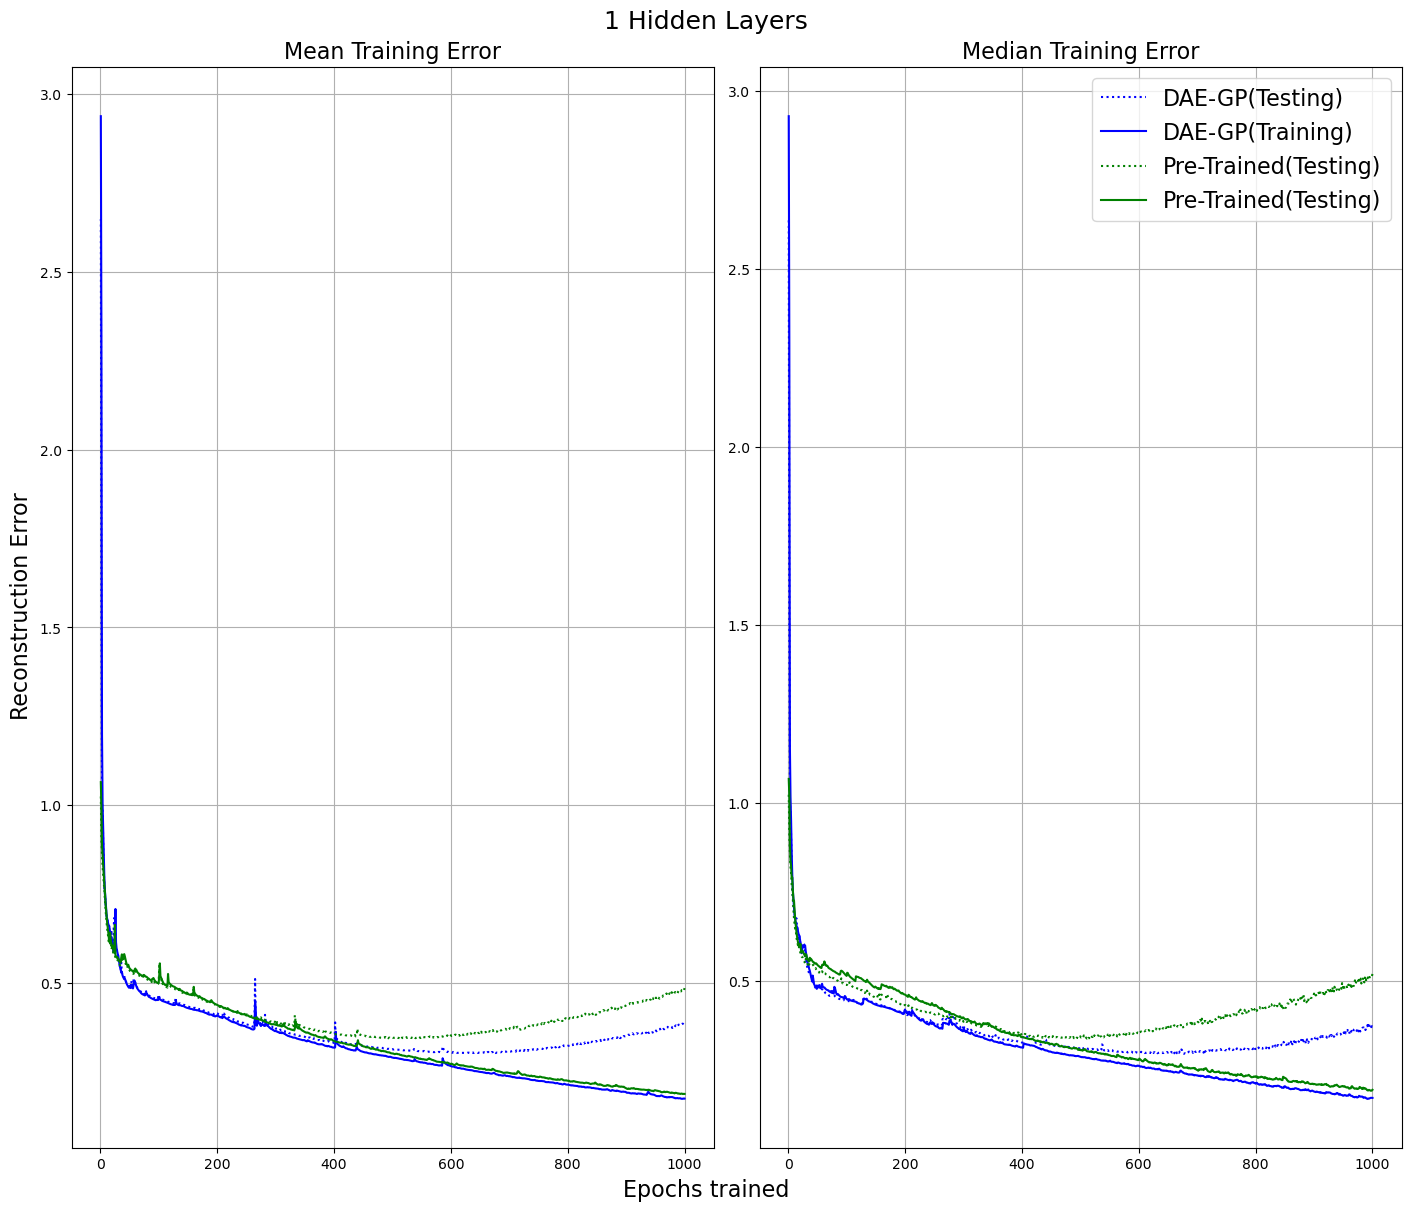

In [13]:
SMALL=14
MID=16
BIG=18

fig, (ul,ur) = plt.subplots(ncols=2, layout="constrained")
fig.set_size_inches(14,12)
epochs = np.arange(1,1001)

#fig.suptitle("Airfoil first Generation", fontsize=BIG)
fig.suptitle(f"{HIDDENLAYERS} Hidden Layers", fontsize=BIG)
fig.supxlabel("Epochs trained", fontsize=MID)
fig.supylabel("Reconstruction Error", fontsize=MID)


reg_train = np.array([reg_errors[x]["training"] for x in reg_test_nums])
reg_test = np.array([reg_errors[x]["testing"] for x in reg_test_nums])
pt_train = np.array([pt_errors[x]["training"] for x in pt_test_nums])
pt_test = np.array([pt_errors[x]["testing"] for x in pt_test_nums])

# ul
reg_train_means = reg_train.mean(axis=0)
reg_test_means = reg_test.mean(axis=0)
pt_train_means = pt_train.mean(axis=0)
pt_test_means = pt_test.mean(axis=0)

ul.plot(epochs, reg_test_means,"b" ,linestyle="dotted", label="DAE-GP(Testing)")
ul.plot(epochs, reg_train_means,"b", label="DAE-GP(Training)")
ul.plot(epochs, pt_test_means, "g", linestyle="dotted", label="Pre-Trained(Testing)")
ul.plot(epochs, pt_train_means, "g", label="Pre-Trained(Testing)")

ul.set_title("Mean Training Error",fontsize=MID)
ul.grid()




# ur
reg_train_median = np.median(reg_train, axis=0)
reg_test_median = np.median(reg_test, axis=0)
pt_train_median = np.median(pt_train, axis=0)
pt_test_median = np.median(pt_test, axis=0)

ur.plot(epochs, reg_test_median,"b" ,linestyle="dotted", label="DAE-GP(Testing)")
ur.plot(epochs, reg_train_median,"b", label="DAE-GP(Training)")
ur.plot(epochs, pt_test_median, "g", linestyle="dotted", label="Pre-Trained(Testing)")
ur.plot(epochs, pt_train_median, "g", label="Pre-Trained(Testing)")

ur.set_title("Median Training Error",fontsize=MID)
ur.grid()
ur.legend(fontsize=MID)
